# Data
This study leverages data acquired from SeatData.io, encompassing comprehensive ticket order details of Inter Miami from 2021 to 2024. The dataset includes specific information such as ticket price, purchase time, seating zone, row, and quantity of tickets bought, oering a detailed view of the pricing landscape. The following is the data description table:

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import random; random.seed(10) # pre-setting seed
from scipy import stats
from scipy import optimize  # for Box-Cox calculations
from scipy.stats import norm, gamma, uniform
from matplotlib import rcParams # for ease of resizing plots
from IPython.display import display

# Numpy version matters for scipy

# For model fitting
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from fitter import Fitter # might require install, numpy version matters
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn import metrics

# Subset regressions & feature selection
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Boruta
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy

# For R kernel
# Note: need working copy of R, initiate chunk with `%%R`
import rpy2.ipython
%load_ext rpy2.ipython

In [2]:
data = pd.read_csv('Inter_Miami.csv')
data.head()

,Date/Time (EDT),Zone,Section,Row,Qty,Price,datevalue,opponent,year,month,date,day,stadium,Home,Messi_Played,PurchaseDate,DaysToGame
0,04-18-21 / 01:45 PM,goal,Goal 124,6,3.0,71.25,2021-04-18,LA Galaxy,2021,4,18,7,DRV PNK,1,0,2021-04-18,0.0
1,04-18-21 / 01:45 PM,sideline,Sideline 120,34,2.0,95.00,2021-04-18,LA Galaxy,2021,4,18,7,DRV PNK,1,0,2021-04-18,0.0
2,04-18-21 / 01:45 PM,Standing Supporters GA,Safe Standing Supporters 107,23,2.0,94.05,2021-04-18,LA Galaxy,2021,4,18,7,DRV PNK,1,0,2021-04-18,0.0
3,04-18-21 / 01:45 PM,Standing Supporters GA,Safe Standing Supporters 108,29,2.0,84.55,2021-04-18,LA Galaxy,2021,4,18,7,DRV PNK,1,0,2021-04-18,0.0
4,04-18-21 / 01:45 PM,Standing Supporters GA,Safe Standing Supporters 106,6,1.0,59.85,2021-04-18,LA Galaxy,2021,4,18,7,DRV PNK,1,0,2021-04-18,0.0


### **Model**

To analyze the impact of Messi joining Inter Miami on ticket prices, we employ a multiple linear regression model. This model accounts for various factors that could influence ticket prices, ensuring a comprehensive analysis of Messi's effect.

$$
\begin{aligned}
\log(\text{Price}) &= \beta_0 + \beta_1 \cdot \text{Messi} + \beta_2 \cdot \text{Played} + \beta_3 \cdot \text{Zone} \\
&\quad + \beta_4 \cdot (\text{Messi} \cdot \text{Zone}) + \beta_5 \cdot \text{Opponent} + \beta_6 \cdot \text{Home} \\
&\quad + \beta_7 \cdot (\text{Messi} \cdot \text{Home}) + \beta_8 \cdot \text{DaysToGame} + \beta_9 \cdot \text{Weekend} \\
&\quad + \beta_{10} \cdot \text{Month} + \beta_{11} \cdot \text{Year} + \epsilon
\end{aligned}
$$

---

### **Variable Descriptions**

| **Variable**        | **Description**                                                                 |
|----------------------|---------------------------------------------------------------------------------|
| $\text{Messi}$       | Binary variable indicating whether Messi was part of the team (1 if post-Messi, 0 otherwise). |
| $\text{Played}$      | Binary variable indicating whether Messi played in the game (1 if yes, 0 otherwise). |
| $\text{Zone}$        | Seating category of the ticket, represented as dummy variables.                |
| $\text{Messi*Zone}$  | Interaction term between Messi's presence and seating zone.                    |
| $\text{Opponent}$    | Opposing team, represented as dummy variables.                                 |
| $\text{Home}$        | Binary variable for whether the game is a home game (1) or not (0).            |
| $\text{Messi*Home}$  | Interaction term between Messi's presence and whether it is a home game.       |
| $\text{DaysToGame}$  | Number of days before the game when the ticket was purchased.                  |
| $\text{Weekend}$     | Binary variable indicating whether the game is on a weekend (1) or a weekday (0). |
| $\text{Month}$       | Month of the game, represented as dummy variables.                             |
| $\text{Year}$        | Year of the game, represented as dummy variables.                              |

# Set variables

In [3]:
# Create the 'Messi' column using a combined condition with '&'
data['Messi'] = (
    (data['year'] > 2023) | 
    ((data['year'] == 2023) & (data['month'] > 7)) | 
    ((data['year'] == 2023) & (data['month'] == 7) & (data['date'] >= 15))
).astype(int)

In [4]:
# Filter data for years 2023 and 2024
filtered_data = data[data['year'].isin([2023, 2024])]

# Group data by month, year, and Messi, then count observations
month_observation = filtered_data.groupby(['month', 'year', 'Messi']).size().reset_index(name='Observations')

# Pivot the table to show months as rows, years and Messi as columns
pivot_table = month_observation.pivot(index='month', columns=['year', 'Messi'], values='Observations').fillna(0)

# Display the resulting pivot table
pivot_table

year     2024    2023        
Messi       1       0       1
month                        
1       466.0     0.0     0.0
2      2288.0   425.0     0.0
3      2880.0  1023.0     0.0
4      2163.0  1412.0     0.0
5      5074.0   912.0     0.0
6      2127.0  1005.0     0.0
7       724.0   844.0   828.0
8      1390.0     0.0  4065.0
9      2206.0     0.0  5187.0
10     1340.0     0.0  3391.0

In [5]:
# Replace spaces and periods in the 'zone' column values with underscores
data['Zone'] = data['Zone'].str.replace(" ", "_").str.replace("-", "_").str.replace(".", "", regex=False).str.title()

# Count the number of observations for each Zone
zone_counts = data['Zone'].value_counts()

# Filter Zones with 100 or more observations
zones_to_keep = zone_counts[zone_counts >= 500].index

# Filter the data to include only Zones with 100 or more observations
filtered_data = data[data['Zone'].isin(zones_to_keep)]

# Group by 'Zone' and calculate the mean of 'Price'
zone_price_avg = filtered_data.groupby('Zone')['Price'].mean()

# Convert the result to a DataFrame for easier processing
zone_price_avg = zone_price_avg.reset_index()

# Rename columns for clarity
zone_price_avg.columns = ['Zone', 'Average_Price']

# Sort by 'Average_Price' in descending order
zone_price_avg = zone_price_avg.sort_values(by='Average_Price', ascending=False)

# Display the result
print(zone_price_avg)

                      Zone  Average_Price
3                    Lower     414.030059
9         South_Grandstand     380.750597
12                   Upper     282.357278
0                100_Level     273.612730
4          Lower_100_Level     256.422791
5           Lower_Sideline     235.069859
13          Upper_Sideline     233.433042
8        South_East_Corner     190.450568
7                 Sideline     187.604281
11              Supporters     171.848128
6        North_East_Corner     169.726588
1                300_Level     168.532331
2                     Goal     138.981942
10  Standing_Supporters_Ga      29.644063


In [6]:
# Identify Zones with 100 or more observations
zone_counts = data['Zone'].value_counts()
valid_zones = zone_counts[zone_counts >= 500].index

# Filter the data to include only the valid Zones
filtered_data = data[data['Zone'].isin(valid_zones)]

# Group by Zone and Year, and count the number of observations
zone_year_counts = filtered_data.groupby(['Zone', 'year']).size().reset_index(name='Count')

# Create a pivot table to display Zones as rows and Years as columns
pivot_table = zone_year_counts.pivot(index='Zone', columns='year', values='Count').fillna(0)

# Reset the index to make it a clean DataFrame
pivot_table = pivot_table.reset_index()

# Add a column to indicate whether all years have observations
pivot_table['All Years Present'] = (pivot_table.iloc[:, 1:] > 0).all(axis=1).astype(int)

# Display the resulting DataFrame
pivot_table

year,Zone,2021,2022,2023,2024,All Years Present
0,100_Level,0.0,0.0,448.0,563.0,0
1,300_Level,0.0,0.0,533.0,162.0,0
2,Goal,1075.0,597.0,2177.0,1758.0,1
3,Lower,0.0,0.0,1447.0,3269.0,0
4,Lower_100_Level,0.0,0.0,927.0,954.0,0
5,Lower_Sideline,195.0,257.0,328.0,500.0,1
6,North_East_Corner,0.0,0.0,208.0,384.0,0
7,Sideline,1842.0,1693.0,6933.0,4017.0,1
8,South_East_Corner,0.0,0.0,219.0,292.0,0
9,South_Grandstand,0.0,43.0,29.0,447.0,0


In [7]:
# Group by Zone and calculate descriptive statistics for Price
zone_price = filtered_data.groupby('Zone')['Price'].describe()

# Filter to display only Goal and Sideline zones
filtered_zone_price = zone_price.loc[['Goal', 'Sideline']]

# Display the result
filtered_zone_price


,count,mean,std,min,25%,50%,75%,max
Zone,,,,,,,,
Goal,5607.0,138.981942,123.021277,3.80,31.50,113.73,216.615,1800.0
Sideline,14485.0,187.604281,151.448844,1.84,49.47,176.63,277.340,1800.0


In [8]:
# Zone dummy creation

# Replace spaces and periods in the 'zone' column values with underscores
data['Zone'] = data['Zone'].str.replace(" ", "_").str.replace("-", "_").str.replace(".", "", regex=False).str.title()

# Create dummy variables without using drop_first
zone_dummies = pd.get_dummies(data['Zone'], prefix='Zone')

# Drop the 'zone_Upper' column explicitly
zone_dummies = zone_dummies.drop('Zone_Goal', axis=1)

# Add the dummy variables back to the original DataFrame
data = pd.concat([data, zone_dummies], axis=1)

# Check the resulting dummy columns
print(data.head())

       Date/Time (EDT)                    Zone                       Section  \
0  04-18-21 / 01:45 PM                    Goal                      Goal 124   
1  04-18-21 / 01:45 PM                Sideline                  Sideline 120   
2  04-18-21 / 01:45 PM  Standing_Supporters_Ga  Safe Standing Supporters 107   
3  04-18-21 / 01:45 PM  Standing_Supporters_Ga  Safe Standing Supporters 108   
4  04-18-21 / 01:45 PM  Standing_Supporters_Ga  Safe Standing Supporters 106   

  Row  Qty  Price   datevalue   opponent  year  month  ...  \
0   6  3.0  71.25  2021-04-18  LA Galaxy  2021      4  ...   
1  34  2.0  95.00  2021-04-18  LA Galaxy  2021      4  ...   
2  23  2.0  94.05  2021-04-18  LA Galaxy  2021      4  ...   
3  29  2.0  84.55  2021-04-18  LA Galaxy  2021      4  ...   
4   6  1.0  59.85  2021-04-18  LA Galaxy  2021      4  ...   

   Zone_Upper_Sideline  Zone_Upper_Tier Zone_Upper_Vip_Club  Zone_Vip_Boxes  \
0                False            False               False        

In [9]:
# Opponent dummy creation

# Replace spaces and periods in the 'opponent' column values with underscores
data['opponent'] = data['opponent'].str.replace(" ", "_").str.replace(".", "", regex=False)

# Create dummy variables without using drop_first
opponent_dummies = pd.get_dummies(data['opponent'], prefix='Opponent')

# Drop the 'opponent_Chicago_Fire' column explicitly
opponent_dummies = opponent_dummies.drop('Opponent_Chicago_Fire', axis=1)

# Add the dummy variables back to the original DataFrame
data = pd.concat([data, opponent_dummies], axis=1)

# Check the resulting dummy columns
print(data.head())

       Date/Time (EDT)                    Zone                       Section  \
0  04-18-21 / 01:45 PM                    Goal                      Goal 124   
1  04-18-21 / 01:45 PM                Sideline                  Sideline 120   
2  04-18-21 / 01:45 PM  Standing_Supporters_Ga  Safe Standing Supporters 107   
3  04-18-21 / 01:45 PM  Standing_Supporters_Ga  Safe Standing Supporters 108   
4  04-18-21 / 01:45 PM  Standing_Supporters_Ga  Safe Standing Supporters 106   

  Row  Qty  Price   datevalue   opponent  year  month  ...  \
0   6  3.0  71.25  2021-04-18  LA_Galaxy  2021      4  ...   
1  34  2.0  95.00  2021-04-18  LA_Galaxy  2021      4  ...   
2  23  2.0  94.05  2021-04-18  LA_Galaxy  2021      4  ...   
3  29  2.0  84.55  2021-04-18  LA_Galaxy  2021      4  ...   
4   6  1.0  59.85  2021-04-18  LA_Galaxy  2021      4  ...   

   Opponent_New_York_Red_Bulls  Opponent_Orlando_City_SC  \
0                        False                     False   
1                        F

In [10]:
# Convert 'datevalue' to datetime if it's not already in datetime format
data['datevalue'] = pd.to_datetime(data['datevalue'])

# Create 'is_weekend' column: 0 for weekdays, 1 for weekends
data['Weekend'] = data['datevalue'].dt.dayofweek.apply(lambda x: 1 if x >= 5 else 0)

# Check the resulting DataFrame
print(data[['datevalue', 'Weekend']].head())

   datevalue  Weekend
0 2021-04-18        1
1 2021-04-18        1
2 2021-04-18        1
3 2021-04-18        1
4 2021-04-18        1


In [11]:
# Create dummy variables for 'month', dropping the first category as a reference
month_dummies = pd.get_dummies(data['month'], prefix='Month', drop_first=True)

# Create dummy variables for 'year', without dropping any category
year_dummies = pd.get_dummies(data['year'], prefix='Year')

# Drop the dummy variable for 2022
year_dummies = year_dummies.drop(columns=['Year_2023'])

# Add the dummy variables back to the original DataFrame
data = pd.concat([data, month_dummies, year_dummies], axis=1)

# Check the resulting dummy columns
print(data.head())

       Date/Time (EDT)                    Zone                       Section  \
0  04-18-21 / 01:45 PM                    Goal                      Goal 124   
1  04-18-21 / 01:45 PM                Sideline                  Sideline 120   
2  04-18-21 / 01:45 PM  Standing_Supporters_Ga  Safe Standing Supporters 107   
3  04-18-21 / 01:45 PM  Standing_Supporters_Ga  Safe Standing Supporters 108   
4  04-18-21 / 01:45 PM  Standing_Supporters_Ga  Safe Standing Supporters 106   

  Row  Qty  Price  datevalue   opponent  year  month  ...  Month_5  Month_6  \
0   6  3.0  71.25 2021-04-18  LA_Galaxy  2021      4  ...    False    False   
1  34  2.0  95.00 2021-04-18  LA_Galaxy  2021      4  ...    False    False   
2  23  2.0  94.05 2021-04-18  LA_Galaxy  2021      4  ...    False    False   
3  29  2.0  84.55 2021-04-18  LA_Galaxy  2021      4  ...    False    False   
4   6  1.0  59.85 2021-04-18  LA_Galaxy  2021      4  ...    False    False   

  Month_7  Month_8  Month_9 Month_10  Month_

In [12]:
# Create interaction terms using the existing dummy variables
for col in data.columns:
    if col.startswith('Zone_'):
        data[f'Messi_{col}'] = data['Messi'] * data[col]  # Interaction terms for Messi and Zone

data['Messi_Home'] = data['Messi'] * data['Home']  # Interaction term for Messi and Home

/var/folders/83/bnspwbhd6gg532lgt9yhdkv40000gn/T/ipykernel_28847/4026233474.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'Messi_{col}'] = data['Messi'] * data[col]  # Interaction terms for Messi and Zone
/var/folders/83/bnspwbhd6gg532lgt9yhdkv40000gn/T/ipykernel_28847/4026233474.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'Messi_{col}'] = data['Messi'] * data[col]  # Interaction terms for Messi and Zone
/var/folders/83/bnspwbhd6gg532lgt9yhdkv40000gn/T/ipykernel_28847/4026233474.py:4: PerformanceWarning

In [13]:
# drop all NAs
data = data.dropna()

# Monthly average price
This graph shows the monthly average ticket price and quartiles for the Sideline Zone, which had the largest sample size. Before Messi's transfer, the median ticket price consistently remained below $50. However, by July 2023, it exceeded $250. Observing the quartile bands, we can also see an increase in price volatility. This rise in variance is likely influenced by price fluctuations depending on whether Messi participated in the game.

/var/folders/83/bnspwbhd6gg532lgt9yhdkv40000gn/T/ipykernel_28847/2884664486.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sideline_data["datevalue"] = pd.to_datetime(sideline_data["datevalue"])
/var/folders/83/bnspwbhd6gg532lgt9yhdkv40000gn/T/ipykernel_28847/2884664486.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sideline_data["YearMonth"] = sideline_data["datevalue"].dt.to_period("M")


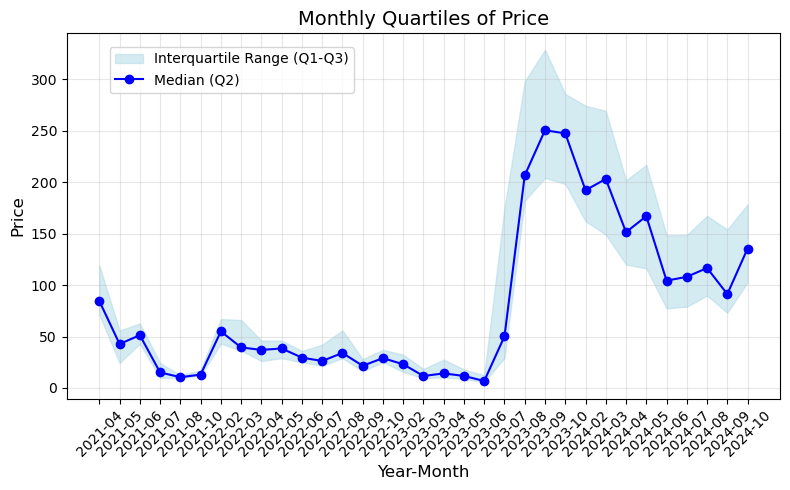

In [14]:
# Filter data where "Zone" is "Sideline"
sideline_data = filtered_data[filtered_data["Zone"] == "Goal"]

# Convert "datevalue" to datetime format
sideline_data["datevalue"] = pd.to_datetime(sideline_data["datevalue"])

# Create a column for Year-Month
sideline_data["YearMonth"] = sideline_data["datevalue"].dt.to_period("M")

# Calculate monthly quartiles for "Price"
monthly_quartiles = sideline_data.groupby("YearMonth")["Price"].quantile([0.25, 0.5, 0.75]).unstack()

# Plot the median line and quartile bands
plt.figure(figsize=(8, 5))

# Plot the quartile band (Q1 to Q3)
plt.fill_between(
    monthly_quartiles.index.astype(str),  # X-axis: Year-Month
    monthly_quartiles[0.25],             # Lower bound (Q1)
    monthly_quartiles[0.75],             # Upper bound (Q3)
    color="lightblue", alpha=0.5,        # Band color and transparency
    label="Interquartile Range (Q1-Q3)"
)

# Plot the median line (Q2)
plt.plot(
    monthly_quartiles.index.astype(str), 
    monthly_quartiles[0.5], 
    color="blue", marker="o", 
    label="Median (Q2)"
)

# Configure the plot
plt.title("Monthly Quartiles of Price", fontsize=14)
plt.xlabel("Year-Month", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.xticks(rotation=45)
plt.legend(
    loc="center left", 
    bbox_to_anchor=(0.05, 0.9),  # Position outside the plot
)
plt.grid(alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()

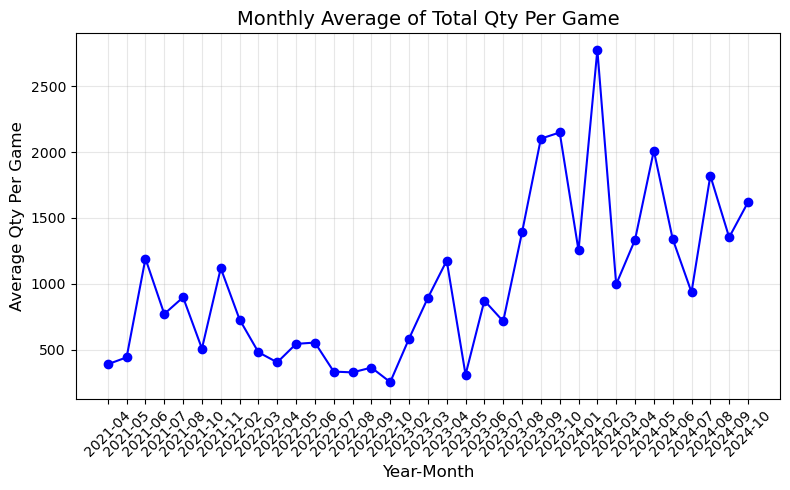

In [15]:
# Convert "datevalue" to datetime format
data["datevalue"] = pd.to_datetime(data["datevalue"])

# Calculate total Qty per game (grouped by datevalue)
game_qty_total = data.groupby("datevalue")["Qty"].sum().reset_index()

# Create a Year-Month column
game_qty_total["YearMonth"] = game_qty_total["datevalue"].dt.to_period("M")

# Calculate monthly average of total Qty
monthly_avg_qty = game_qty_total.groupby("YearMonth")["Qty"].mean()

# Plot the monthly average Qty
plt.figure(figsize=(8, 5))

# Plot the average qty line
plt.plot(
    monthly_avg_qty.index.astype(str), 
    monthly_avg_qty, 
    color="blue", marker="o", 
    label="Monthly Average Qty"
)

# Configure the plot
plt.title("Monthly Average of Total Qty Per Game", fontsize=14)
plt.xlabel("Year-Month", fontsize=12)
plt.ylabel("Average Qty Per Game", fontsize=12)
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()

# Price distirbution (Before and After Messi's arrival)
This graph similarly illustrates the price distribution in the Sideline Zone using histograms. As observed earlier, the mode of the ticket price has increased by approximately $200. Additionally, the shape of the distribution shows significant differences, reflecting the variance in ticket prices.

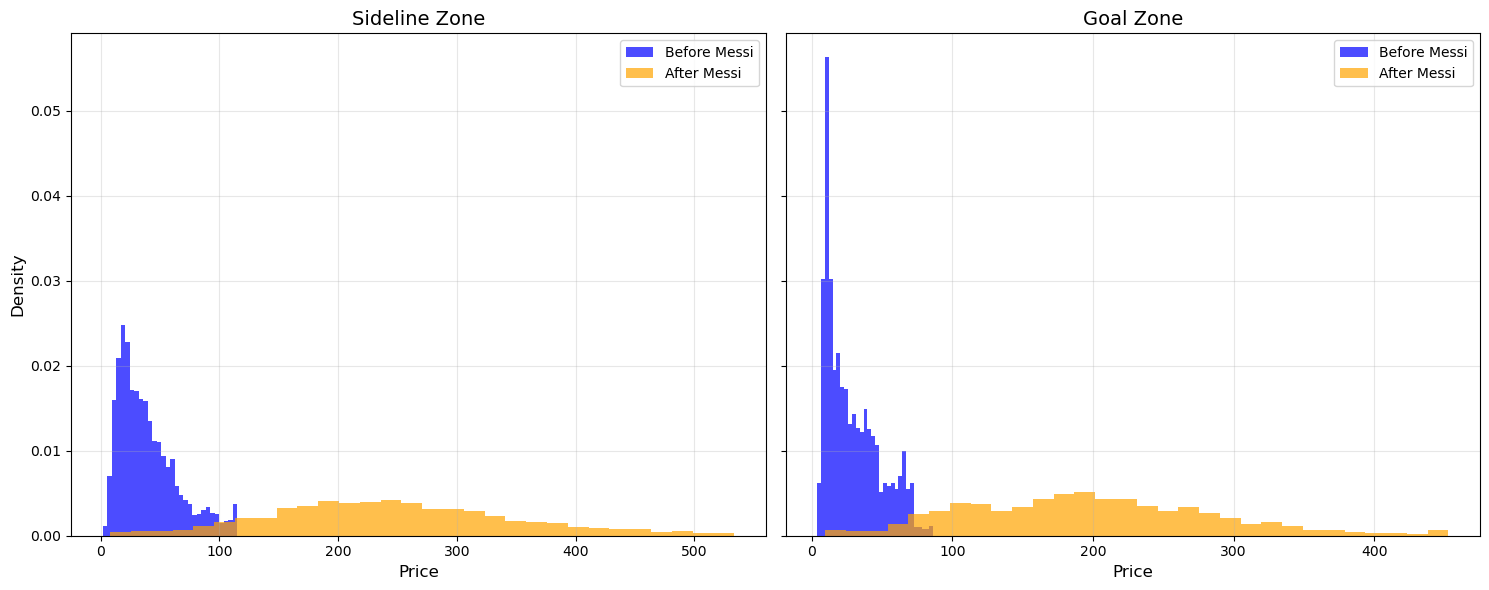

In [16]:
# Filter data where "Zone" is "Sideline" and "Goal"
sideline_data = filtered_data[filtered_data["Zone"] == "Sideline"]
goal_data = filtered_data[filtered_data["Zone"] == "Goal"]

# Filter data for Messi dummy variable
before_messi_sideline = sideline_data[sideline_data["Messi"] == 0]
after_messi_sideline = sideline_data[sideline_data["Messi"] == 1]
before_messi_goal = goal_data[goal_data["Messi"] == 0]
after_messi_goal = goal_data[goal_data["Messi"] == 1]

# Define a function to remove outliers based on IQR
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)  # First quartile (25%)
    Q3 = data[column].quantile(0.75)  # Third quartile (75%)
    IQR = Q3 - Q1  # Interquartile range
    lower_bound = Q1 - 1.5 * IQR  # Lower bound
    upper_bound = Q3 + 1.5 * IQR  # Upper bound
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# Remove outliers from Sideline and Goal data
before_messi_sideline_cleaned = remove_outliers_iqr(before_messi_sideline, "Price")
after_messi_sideline_cleaned = remove_outliers_iqr(after_messi_sideline, "Price")
before_messi_goal_cleaned = remove_outliers_iqr(before_messi_goal, "Price")
after_messi_goal_cleaned = remove_outliers_iqr(after_messi_goal, "Price")

# Create the subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Plot for Sideline zone
axes[0].hist(
    before_messi_sideline_cleaned["Price"], 
    bins=30, alpha=0.7, color="blue", label="Before Messi", density=True
)
axes[0].hist(
    after_messi_sideline_cleaned["Price"], 
    bins=30, alpha=0.7, color="orange", label="After Messi", density=True
)
axes[0].set_title("Sideline Zone", fontsize=14)
axes[0].set_xlabel("Price", fontsize=12)
axes[0].set_ylabel("Density", fontsize=12)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot for Goal zone
axes[1].hist(
    before_messi_goal_cleaned["Price"], 
    bins=30, alpha=0.7, color="blue", label="Before Messi", density=True
)
axes[1].hist(
    after_messi_goal_cleaned["Price"], 
    bins=30, alpha=0.7, color="orange", label="After Messi", density=True
)
axes[1].set_title("Goal Zone", fontsize=14)
axes[1].set_xlabel("Price", fontsize=12)
axes[1].legend()
axes[1].grid(alpha=0.3)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

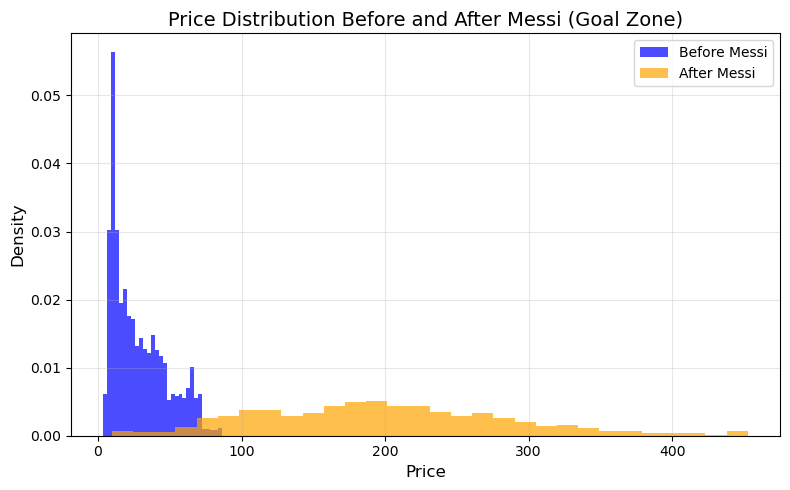

In [17]:
# Filter data where "Zone" is "Goal"
goal_data = filtered_data[filtered_data["Zone"] == "Goal"]

# Filter data for Messi dummy variable
before_messi_goal = goal_data[goal_data["Messi"] == 0]
after_messi_goal = goal_data[goal_data["Messi"] == 1]

# Define a function to remove outliers based on IQR
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)  # First quartile (25%)
    Q3 = data[column].quantile(0.75)  # Third quartile (75%)
    IQR = Q3 - Q1  # Interquartile range
    lower_bound = Q1 - 1.5 * IQR  # Lower bound
    upper_bound = Q3 + 1.5 * IQR  # Upper bound
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# Remove outliers from before and after Messi data
before_messi_cleaned_goal = remove_outliers_iqr(before_messi_goal, "Price")
after_messi_cleaned_goal = remove_outliers_iqr(after_messi_goal, "Price")

# Plot histograms after removing outliers
plt.figure(figsize=(8, 5))

# Histogram for games before Messi (Messi == 0)
plt.hist(
    before_messi_cleaned_goal["Price"], 
    bins=30, alpha=0.7, color="blue", label="Before Messi", density=True
)

# Histogram for games after Messi (Messi == 1)
plt.hist(
    after_messi_cleaned_goal["Price"], 
    bins=30, alpha=0.7, color="orange", label="After Messi", density=True
)

# Configure the plot
plt.title("Price Distribution Before and After Messi (Goal Zone)", fontsize=14)
plt.xlabel("Price", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()

# Price Distribution by Zone
To control for the effect of Messi, this analysis focuses on the 2024 data to examine how ticket prices differ by zone using histograms. The zones compared are the "Lower" zone, which is closer to the field, and the "Upper" zone, which is farther away. In this case, we observe that the mode of the prices differs by approximately $200, and the "Lower" zone, with higher price ranges, shows greater variance.

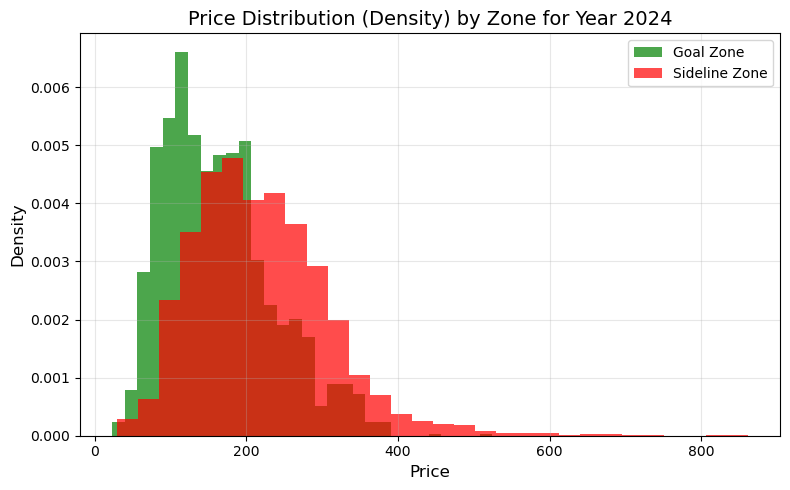

In [18]:
# Filter data for Year 2024
data_2024 = filtered_data[filtered_data["year"] == 2024]

# Filter data by Zone
upper_zone = data_2024[data_2024["Zone"] == "Goal"]
lower_zone = data_2024[data_2024["Zone"] == "Sideline"]

# Plot histograms
plt.figure(figsize=(8, 5))

# Histogram for "Upper" Zone
plt.hist(
    upper_zone["Price"], 
    bins=30, alpha=0.7, color="green", label="Goal Zone", density=True
)

# Histogram for "Lower" Zone
plt.hist(
    lower_zone["Price"], 
    bins=30, alpha=0.7, color="red", label="Sideline Zone", density=True
)

# Configure the plot
plt.title("Price Distribution (Density) by Zone for Year 2024", fontsize=14)
plt.xlabel("Price", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()


# Run model!

In [19]:
no_controls = "np.log(Price) ~ Messi"

dummy_prefixes = ['Opponent_', 'Zone_', 'Messi_Zone_']
key_controls = (
    "np.log(Price) ~ Messi + Messi_Played + Home + Messi_Home + DaysToGame +"
    + " + ".join([col for prefix in dummy_prefixes for col in data.columns if col.startswith(prefix)])
)

dummy_prefixes = ['Opponent_', 'Zone_', 'Messi_Zone_', 'Month_', 'Year_']
all_controls = (
    "np.log(Price) ~ Messi + Messi_Played + Home + Messi_Home + DaysToGame + Weekend + "
    + " + ".join([col for prefix in dummy_prefixes for col in data.columns if col.startswith(prefix)])
)

In [20]:
model_no = smf.ols(formula=no_controls, data=data).fit()
model_key = smf.ols(formula=key_controls, data=data).fit()
model_all = smf.ols(formula=all_controls, data=data).fit()

In [21]:
# Define a function to extract results
def extract_results(model, variables, replace_map=None):
    # Create the DataFrame
    results_df = pd.DataFrame({
        'Variable': variables,
        'Coefficient': [model.params.get(var, None) for var in variables],
        'SE': [model.bse.get(var, None) for var in variables],
        't-value': [model.tvalues.get(var, None) for var in variables],
        'p-value': [model.pvalues.get(var, None) for var in variables]
    })

    # Add significance stars based on p-value
    def add_stars(coef, pval):
        if pval is None:
            return coef
        elif pval < 0.01:
            return f"{coef:.3f}***"
        elif pval < 0.05:
            return f"{coef:.3f}**"
        elif pval < 0.1:
            return f"{coef:.3f}*"
        else:
            return f"{coef:.3f}"

    # Apply the function to add stars
    results_df['Coefficient_with_Sig'] = [
        add_stars(results_df.loc[i, 'Coefficient'], results_df.loc[i, 'p-value'])
        for i in results_df.index
    ]

    # Replace variable names if needed
    if replace_map:
        results_df['Variable'] = results_df['Variable'].replace(replace_map)

    return results_df

# Variables of interest
variables = ['Messi', 'Messi_Played', 'Zone_Sideline[T.True]', 'Messi_Zone_Sideline', 'Opponent_Columbus_Crew[T.True]', 'Home', 'Messi_Home', 'Weekend', 'Year_2023[T.True]', 'Year_2024[T.True]','Intercept']
replace_map = {'Opponent_Columbus_Crew[T.True]': 'Columbus', 'Zone_Sideline[T.True]': 'Sideline', 'Messi_Zone_Sideline': 'Messi_Sideline', 'Year_2023[T.True]':'2023', 'Year_2024[T.True]':'2024'}

# Extract results for each model
results_no = extract_results(model_no, variables, replace_map)
results_key = extract_results(model_key, variables, replace_map)
results_all = extract_results(model_all, variables, replace_map)

# Display the results for each model
display(results_no)
display(results_key)
display(results_all)

,Variable,Coefficient,SE,t-value,p-value,Coefficient_with_Sig
0,Messi,1.811336,0.007165,252.805341,0.0,1.811***
1,Messi_Played,NaN,NaN,NaN,NaN,nan
2,Sideline,NaN,NaN,NaN,NaN,nan
3,Messi_Sideline,NaN,NaN,NaN,NaN,nan
4,Columbus,NaN,NaN,NaN,NaN,nan
5,Home,NaN,NaN,NaN,NaN,nan
6,Messi_Home,NaN,NaN,NaN,NaN,nan
7,Weekend,NaN,NaN,NaN,NaN,nan
8,2023,NaN,NaN,NaN,NaN,nan
9,2024,NaN,NaN,NaN,NaN,nan


,Variable,Coefficient,SE,t-value,p-value,Coefficient_with_Sig
0,Messi,1.630668,0.034481,47.291502,0.000000e+00,1.631***
1,Messi_Played,0.098079,0.009273,10.577199,4.068252e-26,0.098***
2,Sideline,0.377788,0.014633,25.817505,5.933344e-146,0.378***
3,Messi_Sideline,-0.144570,0.018662,-7.746748,9.616311e-15,-0.145***
4,Columbus,0.432051,0.021529,20.067947,3.338108e-89,0.432***
5,Home,-0.466755,0.026192,-17.820741,8.360067e-71,-0.467***
6,Messi_Home,0.398711,0.031656,12.594986,2.576579e-36,0.399***
7,Weekend,NaN,NaN,NaN,NaN,nan
8,2023,NaN,NaN,NaN,NaN,nan
9,2024,NaN,NaN,NaN,NaN,nan


,Variable,Coefficient,SE,t-value,p-value,Coefficient_with_Sig
0,Messi,3.162526,0.039250,80.572984,0.000000e+00,3.163***
1,Messi_Played,0.169064,0.010521,16.069661,5.950142e-58,0.169***
2,Sideline,0.379207,0.013634,27.812399,7.270069e-169,0.379***
3,Messi_Sideline,-0.174925,0.017378,-10.065955,8.260379e-24,-0.175***
4,Columbus,0.796899,0.022386,35.597367,7.013876e-274,0.797***
5,Home,-0.140234,0.026592,-5.273541,1.344081e-07,-0.140***
6,Messi_Home,-0.049764,0.031506,-1.579526,1.142222e-01,-0.050
7,Weekend,0.146293,0.008770,16.680776,2.736556e-62,0.146***
8,2023,NaN,NaN,NaN,NaN,nan
9,2024,-0.774806,0.011263,-68.792525,0.000000e+00,-0.775***


In [22]:
# Extract model summary metrics including F-statistic
def extract_model_metrics(models, model_names):
    results = {
        'Model': model_names,
        'Observations': [int(model.nobs) for model in models],  # Number of observations
        'R-squared': [model.rsquared for model in models],      # R^2
        'Adj. R-squared': [model.rsquared_adj for model in models],  # Adjusted R^2
    }
    return pd.DataFrame(results)

# List of models and their names
models = [model_no, model_key, model_all]
model_names = ['No Controls', 'Key Controls', 'All Controls']

# Create the results DataFrame
metrics_df = extract_model_metrics(models, model_names)

# Display the DataFrame in Jupyter Notebook
metrics_df

,Model,Observations,R-squared,Adj. R-squared
0,No Controls,47170,0.575364,0.575355
1,Key Controls,47170,0.730447,0.728878
2,All Controls,47170,0.767495,0.766072


In [23]:
# Function to calculate percentage increase, 95% CI, and add significance stars to Price Increase (%)
def calculate_price_increase_with_stars(df):
    results = []
    for index, row in df.iterrows():
        if pd.notna(row['Coefficient']):
            # Calculate percentage increase and confidence intervals
            price_increase = (np.exp(row['Coefficient']) - 1) * 100  # Percentage increase
            ci_lower = (np.exp(row['Coefficient'] - 1.96 * row['SE']) - 1) * 100  # Lower CI
            ci_upper = (np.exp(row['Coefficient'] + 1.96 * row['SE']) - 1) * 100  # Upper CI
            
            # Add significance stars to Price Increase (%)
            if row['p-value'] < 0.01:
                price_increase_with_sig = f"{price_increase:.2f}***"
            elif row['p-value'] < 0.05:
                price_increase_with_sig = f"{price_increase:.2f}**"
            elif row['p-value'] < 0.1:
                price_increase_with_sig = f"{price_increase:.2f}*"
            else:
                price_increase_with_sig = f"{price_increase:.2f}"

            results.append({
                'Variable': row['Variable'],
                'Price Increase (%)': price_increase_with_sig,  # Add stars to the price increase
                '95% CI Lower (%)': ci_lower,
                '95% CI Upper (%)': ci_upper
            })
    return pd.DataFrame(results)

# Apply the updated function
price_increase_no_controls = calculate_price_increase_with_stars(results_no)
price_increase_key_controls = calculate_price_increase_with_stars(results_key)
price_increase_all_controls = calculate_price_increase_with_stars(results_all)

# Display results for each model
print("Price Increase Results (No Controls):")
display(price_increase_no_controls)

print("\nPrice Increase Results (Key Controls):")
display(price_increase_key_controls)

print("\nPrice Increase Results (All Controls):")
display(price_increase_all_controls)

Price Increase Results (No Controls):


,Variable,Price Increase (%),95% CI Lower (%),95% CI Upper (%)
0,Messi,511.86***,503.329230,520.514899
1,Intercept,3925.66***,3878.721855,3973.156418



Price Increase Results (Key Controls):


,Variable,Price Increase (%),95% CI Lower (%),95% CI Upper (%)
0,Messi,410.73***,377.352356,446.438204
1,Messi_Played,10.30***,8.318372,12.328062
2,Sideline,45.91***,41.780148,50.150640
3,Messi_Sideline,-13.46***,-16.568827,-10.236593
4,Columbus,54.04***,47.676384,60.680594
5,Home,-37.30***,-40.434347,-33.993677
6,Messi_Home,48.99***,40.026961,58.527465
7,Intercept,2743.82***,2569.197780,2929.873499



Price Increase Results (All Controls):


,Variable,Price Increase (%),95% CI Lower (%),95% CI Upper (%)
0,Messi,2263.02***,2088.049098,2451.986583
1,Messi_Played,18.42***,16.002719,20.886822
2,Sideline,46.11***,42.259594,50.069808
3,Messi_Sideline,-16.05***,-18.859360,-13.139322
4,Columbus,121.87***,112.340700,131.816711
5,Home,-13.08***,-17.498547,-8.434321
6,Messi_Home,-4.85,-10.552186,1.205918
7,Weekend,15.75***,13.780780,17.760465
8,2024,-53.92***,-54.926753,-52.892153
9,Intercept,547.79***,457.038542,653.332170


# Economic interpretation

In [64]:
# Calculate the mean price for rows where Zone is 'Upper' and Messi is 0
mean_price_messi_0 = data[(data['Zone'] == 'Goal') & (data['Messi'] == 0)]['Price'].mean()
mean_price_messi_1 = data[(data['Zone'] == 'Goal') & (data['Messi'] == 1)]['Price'].mean()


# Display the result
print("Mean price for Zone='Goal' and Messi=0:", mean_price_messi_0)
print("Mean price for Zone='Goal' and Messi=1:", mean_price_messi_1)

Mean price for Zone='Goal' and Messi=0: 32.75608773500448
Mean price for Zone='Goal' and Messi=1: 209.07476162097737


In [66]:
# Filter the data for Messi = 1 and Messi = 0
messi_1_data = data[data['Messi'] == 1]
messi_0_data = data[data['Messi'] == 0]

# Group by 'datevalue' and calculate the sum of 'Qty' for each game
total_qty_per_game_messi_1 = messi_1_data.groupby('datevalue')['Qty'].sum()
total_qty_per_game_messi_0 = messi_0_data.groupby('datevalue')['Qty'].sum()

# Calculate the average of total quantity for each case
average_qty_messi_1 = total_qty_per_game_messi_1.mean()
average_qty_messi_0 = total_qty_per_game_messi_0.mean()
increase_qty = average_qty_messi_1/average_qty_messi_0

# Print the results
print(f"Average Total Quantity (Messi=1): {average_qty_messi_1}")
print(f"Average Total Quantity (Messi=0): {average_qty_messi_0}")
print(f"Increase : {increase_qty}")

Average Total Quantity (Messi=1): 1578.0754716981132
Average Total Quantity (Messi=0): 537.0138888888889
Increase : 2.938612025404478


In [67]:
# price estimate
key_param = 410.73/100
all_param = 2263.02/100
key_price = mean_price_messi_0 * (1 + key_param)
all_price = mean_price_messi_0 * (1 + all_param)

print(f"key price : {key_price}")
print(f"all price : {all_price}")

key price : 167.29516688898838
all price : 774.0329043957028


In [69]:
# Calculate revenues
revenue_0 = mean_price_messi_0 * average_qty_messi_0
revenue_key = key_price * average_qty_messi_1
revenue_all = all_price * average_qty_messi_1
inc_key = revenue_key - revenue_0
inc_all = revenue_all - revenue_0

# Print the results
print(f"Revenue before Messi's arrival (average per game): ${revenue_0:.2f}")
print(f"Revenue after Messi's arrival (key-controls model, average per game): ${revenue_key:.2f}")
print(f"Revenue after Messi's arrival (all-controls model, average per game): ${revenue_all:.2f}")
print(f"Increase in revenue (key-controls model, per game): ${inc_key:.2f}")
print(f"Increase in revenue (all-controls model, per game): ${inc_all:.2f}")

# If extrapolating to annual revenue (34 games)
annual_inc_key = inc_key * 34
annual_inc_all = inc_all * 34

print(f"Annual increase in revenue (key-controls model): ${annual_inc_key:.2f}")
print(f"Annual increase in revenue (all-controls model): ${annual_inc_all:.2f}")

Revenue before Messi's arrival (average per game): $17590.47
Revenue after Messi's arrival (key-controls model, average per game): $264004.40
Revenue after Messi's arrival (all-controls model, average per game): $1221482.34
Increase in revenue (key-controls model, per game): $246413.93
Increase in revenue (all-controls model, per game): $1203891.87
Annual increase in revenue (key-controls model): $8378073.46
Annual increase in revenue (all-controls model): $40932323.47


# Summary (for reference)

In [41]:
model_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(Price)   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     539.2
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        10:24:40   Log-Likelihood:                -36885.
No. Observations:               47170   AIC:                         7.435e+04
Df Residuals:                   46882   BIC:                         7.687e+04
Df Model:                         287                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================================
                                                                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                 2.6849      0.074     36.098      0.000       2.539       2.831
Opponent_Atlanta_United_FC[T.True]                                        0.1662      0.022      7.565      0.000       0.123       0.209
Opponent_Austin_FC[T.True]                                                1.1817      0.031     38.702      0.000       1.122       1.242
Opponent_CF_Montreal[T.True]                                              0.2031      0.021      9.532      0.000       0.161       0.245
Opponent_Charlotte_FC[T.True]                                             0.2223      0.021     10.709      0.000       0.182       0.263
Opponent_Colorado_Rapids[T.True]                                         -0.0555      0.035     -1.605      0.109      -0.123       0.012
Opponent_Columbus_Crew[T.True]                                            0.7969      0.022     35.597      0.000       0.753       0.841
Opponent_DC_United[T.True]                                                0.3214      0.022     14.382      0.000       0.278       0.365
Opponent_FC_Cincinnati[T.True]                                            0.3026      0.022     13.880      0.000       0.260       0.345
Opponent_FC_Dallas[T.True]                                                0.1282      0.055      2.333      0.020       0.021       0.236
Opponent_Houston_Dynamo[T.True]                                           0.6746      0.024     28.124      0.000       0.628       0.722
Opponent_LAFC[T.True]                                                     0.7696      0.031     24.508      0.000       0.708       0.831
Opponent_LA_Galaxy[T.True]                                                0.4725      0.027     17.580      0.000       0.420       0.525
Opponent_Minnesota_United_FC[T.True]                                      0.5287      0.058      9.169      0.000       0.416       0.642
Opponent_Nashville_SC[T.True]                                             0.0840      0.019      4.430      0.000       0.047       0.121
Opponent_New_England_Revolution[T.True]                                   0.3042      0.022     14.136      0.000       0.262       0.346
Opponent_New_York_City_FC[T.True]                                         0.2686      0.021     12.800      0.000       0.227       0.310
Opponent_New_York_Red_Bulls[T.True]                                       0.0401      0.021      1.872      0.061      -0.002       0.082
Opponent_Orlando_City_SC[T.True]                                          0.4145      0.020     20.584      0.000       0.375       0.454
Opponent_Philadelphia_Union[T.True]            

In [45]:
model_key.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(Price)   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     465.5
Date:                Mon, 02 Dec 2024   Prob (F-statistic):               0.00
Time:                        11:05:25   Log-Likelihood:                -40372.
No. Observations:               47170   AIC:                         8.129e+04
Df Residuals:                   46896   BIC:                         8.369e+04
Df Model:                         273                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================================
                                                                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                 3.3477      0.032    103.541      0.000       3.284       3.411
Opponent_Atlanta_United_FC[T.True]                                        0.2096      0.021     10.116      0.000       0.169       0.250
Opponent_Austin_FC[T.True]                                                0.6062      0.030     20.310      0.000       0.548       0.665
Opponent_CF_Montreal[T.True]                                              0.2326      0.022     10.426      0.000       0.189       0.276
Opponent_Charlotte_FC[T.True]                                             0.1611      0.020      8.028      0.000       0.122       0.200
Opponent_Colorado_Rapids[T.True]                                          0.0538      0.034      1.561      0.119      -0.014       0.121
Opponent_Columbus_Crew[T.True]                                            0.4321      0.022     20.068      0.000       0.390       0.474
Opponent_DC_United[T.True]                                                0.3493      0.020     17.235      0.000       0.310       0.389
Opponent_FC_Cincinnati[T.True]                                            0.3155      0.020     15.548      0.000       0.276       0.355
Opponent_FC_Dallas[T.True]                                               -0.4213      0.034    -12.519      0.000      -0.487      -0.355
Opponent_Houston_Dynamo[T.True]                                           0.7060      0.023     31.221      0.000       0.662       0.750
Opponent_LAFC[T.True]                                                     1.0873      0.029     37.344      0.000       1.030       1.144
Opponent_LA_Galaxy[T.True]                                                0.7508      0.024     31.881      0.000       0.705       0.797
Opponent_Minnesota_United_FC[T.True]                                      0.6099      0.058     10.499      0.000       0.496       0.724
Opponent_Nashville_SC[T.True]                                             0.2275      0.019     12.223      0.000       0.191       0.264
Opponent_New_England_Revolution[T.True]                                   0.1764      0.020      8.621      0.000       0.136       0.217
Opponent_New_York_City_FC[T.True]                                         0.4006      0.021     19.441      0.000       0.360       0.441
Opponent_New_York_Red_Bulls[T.True]                                       0.1746      0.021      8.507      0.000       0.134       0.215
Opponent_Orlando_City_SC[T.True]                                          0.3876      0.019     20.278      0.000       0.350       0.425
Opponent_Philadelphia_Union[T.True]            